In [1]:
!pip install bayesian-optimization


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from bayes_opt import BayesianOptimization
from skopt.space import Real, Categorical, Integer

In [3]:
df = pd.read_csv("bismillah.csv")

## One-Hot Encoder

In [4]:
from sklearn.preprocessing import OneHotEncoder

df = pd.concat([df, pd.get_dummies(df['kota'], prefix='kota')], axis=1)
df = pd.concat([df, pd.get_dummies(df['kecamatan'], prefix='kecamatan')], axis=1)
df.drop(['kota', 'kecamatan'], axis=1, inplace=True)
df.head()

,kamar_tidur,kamar_mandi,luas,harga,kota_Banjar,kota_Banjarbaru,kota_Banjarmasin,kota_Barito,kota_Kalimantan,kecamatan_Alalak,...,kecamatan_Banjarmasin Tengah,kecamatan_Banjarmasin Timur,kecamatan_Banjarmasin Utara,kecamatan_Gambut,kecamatan_Kertak Hanyar,kecamatan_Landasan Ulin,kecamatan_Liang Anggang,kecamatan_Martapura Kota,kecamatan_Sei/Sungai Tabuk,kecamatan_Tatah Makmur
0,2,2,70,400000000,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,2,1,60,400000000,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,2,1,120,550000000,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,3,2,100,555000000,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,2,1,45,400000000,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False


## Split dataset

In [5]:
X = df.drop(columns=['harga'])
y = df['harga']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Standard Scaler

In [7]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['kamar_mandi', 'kamar_tidur', 'luas']
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train.loc[:, numerical_features])

In [8]:
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

## Bayesian Optimization

In [22]:
def svr_cv(C, gamma, kernel):
    model = svm.SVR(C=C, gamma=gamma, kernel=kernel)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return scores.mean()

In [23]:
def map_kernel(kernel_index):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    return kernels[int(kernel_index)]

def svr_cv_mapped(C, gamma, kernel):
    kernel_mapped = map_kernel(kernel)
    return svr_cv(C, gamma, kernel_mapped)

param_bounds = {
    'C': (0.001, 100),
    'gamma': (0.0001, 0.1),
    'kernel': (0, 3)  # We'll map this to ['linear', 'poly', 'rbf', 'sigmoid']
}

optimizer = BayesianOptimization(
    f=svr_cv_mapped,
    pbounds=param_bounds,
    random_state=42
)

In [26]:
optimizer.maximize(
    init_points=10,  # Number of initial random points
    n_iter=50  # Number of iterations for optimization
)

|   iter    |  target   |     C     |   gamma   |  kernel   |
-------------------------------------------------------------
| 60        | -1.316e+1 | 60.75     | 0.01714   | 0.1952    |
| 61        | -1.316e+1 | 94.89     | 0.09657   | 2.425     |
| 62        | -1.316e+1 | 30.46     | 0.009857  | 2.053     |
| 63        | -1.316e+1 | 44.02     | 0.01229   | 1.486     |
| 64        | -1.316e+1 | 3.44      | 0.09094   | 0.7763    |
| 65        | -1.316e+1 | 66.25     | 0.03124   | 1.56      |
| 66        | -1.316e+1 | 54.67     | 0.01857   | 2.909     |
| 67        | -1.316e+1 | 77.51     | 0.09396   | 2.684     |
| 68        | -1.316e+1 | 59.79     | 0.0922    | 0.2655    |
| 69        | -1.316e+1 | 19.6      | 0.004618  | 0.976     |
| 70        | -1.316e+1 | 38.87     | 0.02721   | 2.486     |
| 71        | -1.316e+1 | 35.68     | 0.02817   | 1.628     |
| 72        | -1.316e+1 | 14.09     | 0.08024   | 0.2237    |
| 73        | -1.316e+1 | 98.69     | 0.07725   | 0.5961    |
| 74    

In [29]:
best_params = optimizer.max['params']
best_params['kernel'] = map_kernel(best_params['kernel'])

best_model = svm.SVR(**best_params)
best_model.fit(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Best parameters: {best_params}")
print(f"Test set score: {test_score}")


Best parameters: {'C': 100.0, 'gamma': 0.1, 'kernel': 'linear'}
Test set score: -0.07929750801811508


## Model development

In [32]:
SVR_new = svm.SVR(C= 100.0, gamma=0.1, kernel='linear')

model = SVR_new.fit(X_train, y_train_scaled)

In [33]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MSE: {mse} and RMSE:{rmse}")

MSE: 4.188304846090571e+17 and RMSE:647171140.1237366


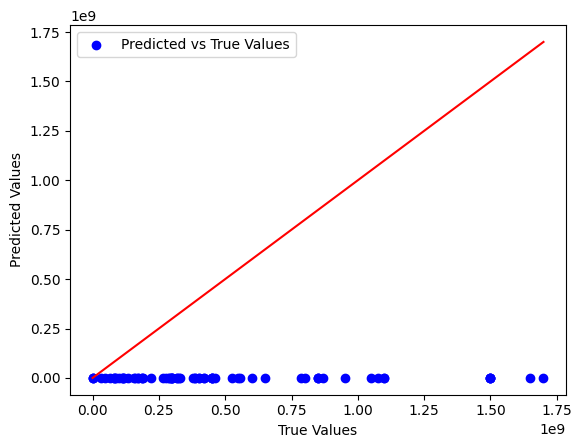

In [34]:
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line for reference
plt.show()